In [84]:
import torch
from torch.nn import functional as F
import numpy as np

import pickle
from os import path
import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, kendalltau

import time
from IPython.display import clear_output
from copy import deepcopy

from collections import defaultdict, OrderedDict

from matplotlib import pyplot as plt

from tqdm import tqdm

In [3]:
with open('players.pkl', 'rb') as fp:
    players = pickle.load(fp)
with open('results.pkl', 'rb') as fp:
    results = pickle.load(fp)
with open('tournaments.pkl', 'rb') as fp:
    tournaments = pickle.load(fp)

In [4]:
tournaments = [tournament for tournament in tournaments.values() if int(tournament['dateStart'][:4]) >= 2019]
tournaments.sort(key = lambda x: datetime.datetime.strptime(x['dateStart'][:10], '%Y-%m-%d'))

Некоторые турниры проходят в несколько раундов, а потому у разных команд разные длины "масок". Такие турниры будет разбивать на несколько "независимых" турниров с разными составами команд, но фиксированным количеством вопросов в каждом турнире.

In [5]:
def split_result(result):
    if len(result) == 0:
        return []
    
    mask_lens = [len(x['mask']) for x in result]
    if min(mask_lens) == max(mask_lens):
        return [result]
    
    min_len = min(mask_lens)
    
    new_result = []
    for team in result:
        if len(team['mask']) > min_len:
            new_team = deepcopy(team)
            new_team['mask'] = team['mask'][min_len:]
            team['mask'] = team['mask'][:min_len]
            new_result.append(new_team)
            
    return [result] + split_result(new_result)

In [6]:
results_train = []
results_test = []
results_train_ids = []

for tmnt in tournaments:
    result = results[tmnt['id']]
    
    if tmnt['dateStart'][:4] == '2020':
        results_test.append(result)
        continue
        
    result = [{'mask': team.get('mask'),
               'teamMembers': [member['player']['id'] for member in team['teamMembers']]}\
                 for team in result]
        
    result = list(filter(lambda x: (x.get('mask') is not None) and (len(x['teamMembers']) > 0), result))
    for team in result:
        team['mask'] = [1 if char=='1' else 0 for char in team['mask']]
    
    split_results = split_result(result)
    split_results = list(filter(lambda x: len(x) > 1, split_results))
    
    results_train += split_results
    results_train_ids += [tmnt['id']]*len(split_results)

In [7]:
players_in_train = set()
for res in results_train:
    for team in res:
        for member in team['teamMembers']:
            players_in_train.add(member)
players_in_train = {key: value for key, value in players.items() if key in players_in_train}

Скоры игроков будут хранится в векторе, и потребуется словарь для перевода id в индекс и обратно.

In [8]:
player_num_to_id = list(players_in_train.keys())
player_id_to_num = {id_: num for num, id_ in enumerate(player_num_to_id)}

Для бейзлайна считаем, что ответ команды == ответ игрока.

In [9]:
def expect_answers_naive(result):
    answers = []
    for team in result:
        for member in team['teamMembers']:
            answers.append(team['mask'])
            
    return answers

In [10]:
def log_loss(player_scores, question_scores, answers):
    with torch.no_grad():
        a = player_scores[:,None] - question_scores[None,:]
        a = answers*F.softplus(-a) + (1 - answers)*F.softplus(a)
    return a.sum()

def log_grad(player_scores, question_scores, answers):
    with torch.no_grad():
        a = player_scores[:,None] - question_scores[None,:]
        a = torch.sigmoid(a) - answers
        player_grads = a.sum(dim = 1)
        question_grads = - a.sum(dim = 0)
    return player_grads, question_grads

def full_loss(player_scores, data):
    loss = 0.
    for dt in data:
        loss += log_loss(player_scores[dt['player_nums']], dt['question_scores'], dt['answers'])\
            /(dt['answers'].shape[0]*dt['answers'].shape[1])
        
    return loss/len(data)

def full_grad(player_scores, data):
    player_scores_grad = torch.zeros_like(player_scores)
    player_question_pairs = 0
    for dt in data:
        n_pairs = dt['answers'].shape[0]*dt['answers'].shape[1] 
        player_grads, question_grads =\
            log_grad(player_scores[dt['player_nums']], dt['question_scores'], dt['answers'])
        player_grads /= n_pairs*len(data)
        question_grads /= n_pairs*len(data)
        dt['question_scores'].grad = question_grads
        player_scores_grad[dt['player_nums']] += player_grads
        
    return player_scores_grad

Теперь будем обновлять скор игроков после каждого турнира. При этом будем также учитывать априорное распределение скора для каждого игрока (берём гауссиану). Правдоподобие также будем приближать гауссианой (для оценки дисперсии можно использовать вторую производную в точке максимального правдоподобия). Тогда получаем следующую схему для обновления скоров игроков:
\begin{equation}
\eta_{new} = \eta_{max} + \eta_{old}, \ s_{new} = \frac{s_{old} * \eta_{old} + s_{max}*\eta_{max}}{\eta_{max} + \eta_{old}}
\end{equation}
Здесь $\eta = 1/\sigma^2$ --- "точность". Такой подход позволяет решить проблему игроков с малым числом игр в топе за счёт регуляризации.

Правда, в такой схеме скрытый параметр $\eta$ всегда растёт. Поэтому в формулах будем заменять $\eta_{max}, \eta_{old}$ на $c*\eta_{max}, (1-c)*\eta_{old}$, чтобы смягчить влияние старых игр и замедлить изменение скора игрока с каждой игрой.

In [305]:
player_scores = torch.zeros(len(player_id_to_num)).float()
player_score_precisions = torch.tensor([0.4]*len(player_id_to_num)).float()

In [306]:
def expect_answers(p_s, q_s, result):
    team_sizes = [len(team['teamMembers']) for team in result]
    p_s_per_team = torch.split(p_s, team_sizes)
    answers = []
    for team, team_p_s in zip(result, p_s_per_team):
        mask = torch.tensor(team['mask'])
        with torch.no_grad():
            expected_answers = torch.sigmoid(team_p_s[:,None] - q_s[None,:])
            expected_answers = expected_answers/(1 - (1 - expected_answers).prod(dim=0))
            expected_answers = expected_answers*mask[None,:]
            answers.append(expected_answers)
            
    answers = torch.cat(answers)

    return answers

In [307]:
def process_tournament(player_scores, result, em_steps = 2, max_opt_steps=100, eps = 1e-3):
    with torch.no_grad():
        player_nums = []
        for team in result:
            player_nums += [player_id_to_num[member] for member in team['teamMembers']]
        player_nums = torch.tensor(player_nums)

        p_s = torch.nn.Parameter(player_scores[player_nums].clone())
        av_p_s = p_s.mean().detach()
        q_s = torch.nn.Parameter(av_p_s*torch.ones(len(result[0]['mask'])).float())

        opt = torch.optim.Adam([p_s, q_s], lr=1e-2)

        for _ in range(em_steps):
            expected_answers = expect_answers(p_s, q_s, result)
            initial_grad_norm = None

            for _ in range(max_opt_steps):
                opt.zero_grad()
                p_s.grad, q_s.grad = log_grad(p_s, q_s, expected_answers)
                grad_norm = torch.norm(torch.cat([p_s.grad, q_s.grad]))
                if initial_grad_norm is None:
                    initial_grad_norm = grad_norm

                opt.step()
                if grad_norm/initial_grad_norm < eps:
                    break

        precisions = (1/4/torch.cosh((p_s[:,None] - q_s[None,:])/2)**2).sum(dim=1)*0.2
        old_precisions = player_score_precisions[player_nums].clone()*0.8

        p_s = p_s.detach() + av_p_s - p_s.mean().detach()
        old_p_s = player_scores[player_nums].clone()

        player_scores[player_nums] = (old_p_s*old_precisions + p_s*precisions)/(old_precisions + precisions)
        player_score_precisions[player_nums] = old_precisions + precisions

    return q_s.detach().numpy() + av_p_s.numpy() - p_s.mean().detach().numpy()

In [308]:
question_scores = []
for result in tqdm(results_train):
    question_scores.append(process_tournament(player_scores, result))

100%|██████████| 734/734 [00:37<00:00, 19.73it/s]


In [208]:
def compute_metric(player_scores, results_test, corr_metric, scores_to_rank_func=lambda x: [-sum(x_) for x_ in x]):
    corrs = []
    for result in results_test:
        if len(result) == 0:
            continue
        
        try:
            true_ranks = [team['position'] for team in result]
        except:
            true_ranks = range(len(result))
            
        if min(true_ranks) == max(true_ranks):
            continue

        scores = []
        av_player_score = player_scores.mean()
        for team in result:
            team_scores = []
            for member in team['teamMembers']:
                player_id = member['player']['id']
                if player_id in player_id_to_num.keys():
                    team_scores.append(player_scores[player_id_to_num[player_id]])
                else:
                    team_scores.append(av_player_score)
            scores.append(team_scores)
        
        pred_ranks = scores_to_rank_func(scores)
        corrs.append(corr_metric(true_ranks, pred_ranks).correlation)
        
    return sum(corrs)/len(corrs)

In [326]:
def scores_to_ranks(scores):
    av_p_score = []
    for s in scores:
        av_p_score += s
    av_p_score = sum(av_p_score)/len(av_p_score)
    
    diff = predict_difficulty(av_p_score)
    
    ranks = []
    for s in scores:
        s = torch.tensor(s)
        ranks.append(-F.softplus(s - diff).sum().item())
        
    return ranks

In [312]:
av_question_scores = np.array([q_s.mean() for q_s in question_scores])
av_player_scores = []
for result in results_train:
    player_nums = []
    for team in result:
        player_nums += [player_id_to_num[member] for member in team['teamMembers']]
    player_nums = torch.tensor(player_nums)
    av_player_scores.append(player_scores[player_nums].mean().item())
av_player_scores = np.array(av_player_scores)

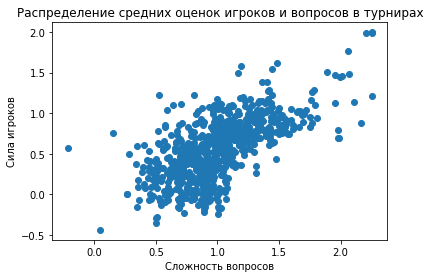

In [317]:
plt.scatter(av_question_scores, av_player_scores)
plt.title('Распределение средних оценок игроков и вопросов в турнирах')
plt.xlabel('Сложность вопросов')
plt.ylabel('Сила игроков')
plt.show()

In [322]:
lin_reg = LinearRegression()
lin_reg.fit(av_player_scores[:,None], av_question_scores)

def predict_difficulty(av_player_score):
    return lin_reg.coef_[0]*av_player_score + lin_reg.intercept_

In [327]:
compute_metric(player_scores, results_test, spearmanr)

0.7021830760736638

In [328]:
compute_metric(player_scores, results_test, spearmanr, scores_to_ranks)

0.7024196011988194

In [329]:
compute_metric(player_scores, results_test, kendalltau)

0.5476602860901648

In [330]:
compute_metric(player_scores, results_test, kendalltau, scores_to_ranks)

0.5509455006301842

In [331]:
player_data = {}
for id_, num in player_id_to_num.items():
    data = {'games': 0, 'score': player_scores[num]}
    player_data[id_] = data\
    
for result in results_train:
    for team in result:
        for member in team['teamMembers']:
            player_data[member]['games'] += 1

In [332]:
sorted(player_data.items(), key = lambda item: item[1]['score'], reverse=True)

[(27403, {'games': 66, 'score': tensor(2.8800)}),
 (28751, {'games': 107, 'score': tensor(2.8746)}),
 (30152, {'games': 139, 'score': tensor(2.8411)}),
 (30270, {'games': 102, 'score': tensor(2.7279)}),
 (27822, {'games': 96, 'score': tensor(2.7210)}),
 (4270, {'games': 79, 'score': tensor(2.7096)}),
 (87637, {'games': 38, 'score': tensor(2.6993)}),
 (7008, {'games': 123, 'score': tensor(2.6113)}),
 (56647, {'games': 57, 'score': tensor(2.5597)}),
 (18332, {'games': 100, 'score': tensor(2.5146)}),
 (20691, {'games': 41, 'score': tensor(2.4766)}),
 (32458, {'games': 109, 'score': tensor(2.4682)}),
 (74382, {'games': 78, 'score': tensor(2.4321)}),
 (14786, {'games': 77, 'score': tensor(2.4166)}),
 (23178, {'games': 60, 'score': tensor(2.4146)}),
 (33620, {'games': 117, 'score': tensor(2.4062)}),
 (66764, {'games': 119, 'score': tensor(2.3949)}),
 (18036, {'games': 35, 'score': tensor(2.3928)}),
 (138832, {'games': 105, 'score': tensor(2.3911)}),
 (12307, {'games': 21, 'score': tensor(2.3

Метрики получаются хуже, чем в базовом варианте. Однако в такой схеме рейтинг игроков меняется "онлайн" после каждой проведённой игры, а в топе действительно 